In [292]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# RBF (Radial Basis Functions) pentru regresie

## 1. Introducere

Vom folosi o reţea RBF cu K centri pentru a realiza o regresie. Intrările regresie (stratului ascuns) vor fi un set de K feature-uri 'fabricate' de cele K funcţii radiale. Pe baza acestora vom construi regresia liniară, care este o combinaţie liniară de aceste intrări radiale. Coeficienţii regresiei liniare se învaţă cu ajutorul algoritmului backpropagation.

Funcţia de activare radială $k$ pentru o intrare $x^{(i)}$, un centroid $c_k$ respectiv o 'lăţime' $\sigma_k$ a gaussienei ce o caracterizează este:

$\varphi_k(x^{(i)}) = exp\left( - \frac{\|x^{(i)}-c_k\|^2}{2\sigma_k^2} \right)$

Funcţia de loss pentru un set de date întreg $x^{(i)}, y^{(i)}$, pentru $i = 1 \dots N$, este:

$J(x, y) = \frac{1}{2}\sum_{i=1}^N \left[ y^{(i)} - f(x^{(i)}) \right]^2$, pentru care:

$f(x^{(i)}) = \sum_{k=1}^K w_k \varphi_k(x^{(i)}) + b$

Vom calcula însă eroarea de propagare înapoi pentru fiecare $x^{(i)}$ în parte, aşa încât funcţia de loss la fiecare pas este:

$J(x^{(i)}, y^{(i)}) = \frac{1}{2} \left[ y^{(i)} - f(x^{(i)}) \right]^2$

Putem astfel construi:

$\frac{\partial J_i}{\partial w_k} = \frac{\partial J}{\partial f_i} \cdot \frac{\partial f_i}{\partial w_k} = - \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, respectiv:

$\frac{\partial J_i}{\partial b} = - \left[ y^{(i)} - f(x^{(i)}) \right]$


Regulile de update devin astfel:

$w_k \leftarrow w_k + \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, şi:

$b \leftarrow b + \left[ y^{(i)} - f(x^{(i)}) \right])$


## 2. Setul de date

Sunt alese aleator 100 de puncte între $[0, 1)$, şi construim o 'sinusoidă' perturbată pentru punctele astfel alese:

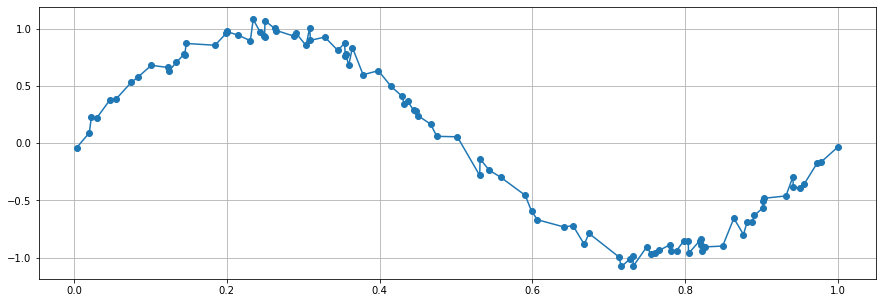

In [293]:
samples = 100
x = np.random.uniform(low=0.0, high=1.0, size=samples)
x = np.sort(x, axis=0)

noise = np.random.uniform(low=-0.1, high=0.1, size=samples)
y = np.sin(2 * np.pi * x)  + noise
 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 


## 3. Algoritmul K-means

K-means este folosit pentru construcţia centroizilor. Acolo vom 'centra' cele K gaussiene.

1. se aleg cei K centri aleator dintre cele 100 de puncte existente
2. calculează distanţa de la fiecare punct la fiecare dintre cei K centroizi
3. pentru fiecare punct, se găseşte cel mai apropiat centroid de punctul respectiv
4. pentru fiecare din cei K centroizi, se recalculează media cluster-ului ca fiind media punctelor celor mai apropiate de acel centroid
5. centroidul devine media astfel calculată
6. repetă paşii 2 - 5 până când centroizii au o deplasare sub $10^{-6}$

Algoritmul K-means va întoarce centroizii împreună cu deviaţia standard a fiecărui cluster, asociat acelui centroid.

Dacă există clustere cu mai puţin de doi reprezentanţi, deviaţia standard ($\sigma$) a acelui cluster va fi calculată ca media deviaţiilor standard ale clusterelor care nu se află în această situaţie.

In [294]:
def kmeans(x, k):
    # choose k centers at random, from existing samples
    # ...
    centers=np.random.choice(x,k)
    converged = False
    while not converged:
        # compute distance from every point to all centers
        # ...
        distances=[np.sqrt((xi-centers)**2) for xi in x]
        clusters={}
        for cluster in range(k):
              clusters[cluster] = []
        # recompute the centers by computing the mean of every cluster
        # ...      
        for index in range(x.shape[0]):
            clusters[np.argmin(distances[index])].append(x[index])

        new_centers = centers.copy()
        for cluster in clusters:
                if len(clusters[cluster])!=0:
                    centers[cluster]=np.average(clusters[cluster],axis=0)
                    
        converged = np.linalg.norm(centers - new_centers) < 1e-6
   
    # compute the standard deviations of clusters
    # ...
    stds=[]
    # find clusters with less than 2 points and make std = 0
    # ...
        
    for cluster in clusters:
        if len(clusters[cluster])>=2:
            stds.append(np.std(clusters[cluster]))
        else:
             stds.append(0)
    
    
    # set that cluster std as the mean of the rest of stds
    # ...
    stds=np.array(stds)
    stds[stds==0]=np.average(stds[stds!=0])
   
   
   
            
    return centers, stds

In [295]:
k = 50
centers, stds = kmeans(x, k)


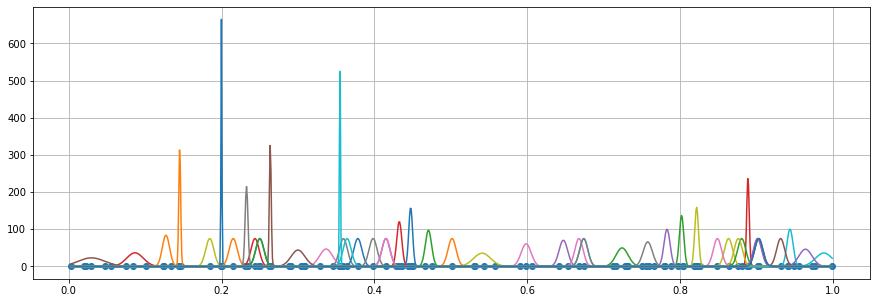

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, np.zeros_like(x), '-o')
v = np.linspace(x.min(), x.max(), 1000)
for i in range(k):
    ax.plot(v, stats.norm.pdf(v, loc=centers[i], scale=stds[i]))
ax.grid() ; plt.show() 

Observaţi cum apar mai multe gaussiene în zonele cu puncte mai dese. Încercaţi să modificaţi numărul de clustere.

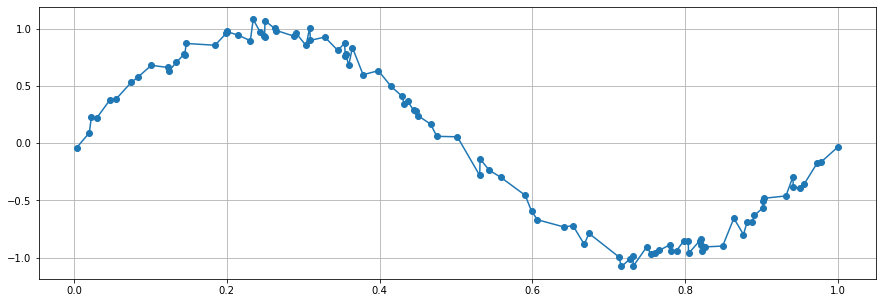

In [297]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

In [298]:
def rbf(x, c, sigma):
    return np.exp(- (x - c) ** 2 / (2 * sigma ** 2))

## 4. Instruirea ponderilor stratului ascuns

Realizaţi, în fiecare epocă, parcurgerea sample cu sample. Pentru fiecare sample $x^{(i)}$ astfel ales, calculaţi valoarea activării (funcţia $f(\cdot)$), loss-ului şi a lui delta.

In [299]:
lr = 0.05
epochs = 200
w = np.random.randn(k)
b = np.random.randn(1)

for epoch in range(epochs):
    for i in range(len(x)):
       
        a=np.array([rbf(x[i], centers[index], stds[index]) for index in range(len(centers))])
        f = np.matmul(a.transpose(),w)+b
        loss = (y[i] - f) ** 2
        delta = -(y[i] - f)
        w = w - lr * a * delta
        b = b - lr * delta


Definiţi funcţia de inferenţă, de calcul a activării pentru fiecare element, $y\_pred^{(i)} = f(x^{(i)})$.

In [300]:
def inference(x):
    y_pred = []
    # ...
    for i in range(x.shape[0]):
        a=np.array([rbf(x[i], centers[index], stds[index]) for index in range(len(centers))])
        f = np.matmul(a.transpose(),w)+b
        y_pred.append(f)
    return np.array(y_pred)   
    

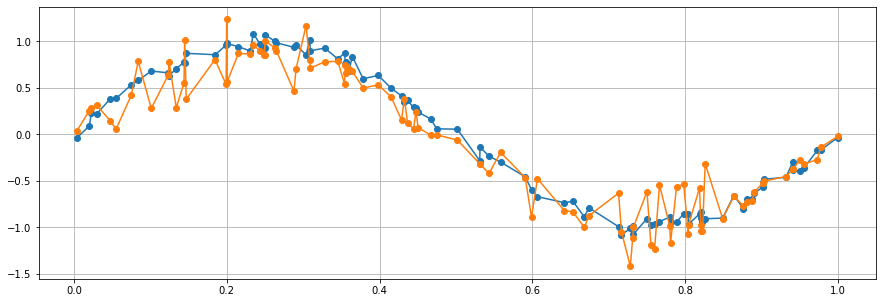

In [301]:
y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.grid() ; plt.show() 

## 5. Fine-tuning

Realizaţi:
* regularizarea ponderilor stratului ascuns
* modificaţi numărul de clustere K şi găsiţi cea mai bună valoare
* găsiţi cel mai bun parametru de regularizare şi cea mai bună rată de învăţare